<h1><center>IBM Machine Learning Professional Certificate</center></h1>
<h2><center>Final Assignment - Course 2</center></h2>
<h3><center>Emily Kendall</center></h3>


In [100]:
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline

# Section 1: Data Summary

### In this section we download the dataset and describe its key properties including size, key variables, and target variable

* First, we use the `astroquery` package to access data from the Sloan Digital Sky Survey. We then construct a database of 1000 astrophysical objects for which photometric data and spectroscopic redshifts are available.
* We restrict our attention to galaxies (ignoring other classes of astrophysical objects, e.g., stars, quasars) and focus only on the low-redshift (z < 0.5) regime, for which observational data is most reliable.
* The resulting Pandas dataframe has the following columns:
    * 'ObjectID': Unique identifier for each object.
    * 'u', 'g', 'r', 'i', 'z': Extinction corrected apparent magnitudes (brightness) in each of 5 photometric bands described below.
    * 'Redshift': Spectroscopic redshift. This is the target variable which we aim to predict.
* The 5 photometric bands are described in the table below:
  
| Band  | Wavelength Range | Color                 |
| ----- | ---------------- | --------------------- |
| **u** | \~300–400 nm     | Ultraviolet (near-UV) |
| **g** | \~400–550 nm     | Blue-green            |
| **r** | \~550–700 nm     | Red                   |
| **i** | \~700–850 nm     | Near-infrared         |
| **z** | \~850–1000 nm    | Deeper near-infrared  |
* Note that the SDSS SkyServer does not store objects in a random order. Therefore, if we simply use, for example "SELECT TOP 1000", we will obtain a sample for which the maximum reshift will be very small (0.000785). Unfortunately, the SDSS SkyServer SQL does not support TABLESAMPLE, and as the database is very large, if we add ORDERBY to our SQL query, the request returns a timeout error. Therefore, in order to get a representative sample which spans our desired redshift range, we have to introduce a loop which traverses the entire range, as shown below.


In [84]:
# create 1000 equal intervals between 0.01 and 0.5
intervals = []
lspace = np.linspace(0.01, 0.5, 1001)
for i in range(1000):
    intervals.append([lspace[i], lspace[i+1]])

# initialise empty pandas dataframe
astro_data = pd.DataFrame()

# Loop through redshift intervals and obtain a representative sample (this may take some time)
for i in tqdm(range(1000)):
    
    # Define SQL query
    query = f"""
    SELECT TOP 1
      p.objid AS ObjectID,
      p.dered_u AS u, 
      p.dered_g AS g, 
      p.dered_r AS r, 
      p.dered_i AS i, 
      p.dered_z AS z,
      s.z AS Redshift,
      s.class AS ObjectType
    FROM PhotoObj AS p
    JOIN SpecObj AS s ON s.bestobjid = p.objid
    WHERE
      s.zWarning = 0 AND
      s.z BETWEEN {intervals[i][0]} AND {intervals[i][1]} AND
      s.class = 'GALAXY'
    """
    
    # Send SQL query to SDSS server and return result
    result = SDSS.query_sql(query)
    
    # Convert result to pandas DataFrame and concatenate with existing DataFrame
    astro_data = pd.concat([astro_data, result.to_pandas()], ignore_index=True)

# Preview the data
astro_data.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.70it/s]


,ObjectID,u,g,r,i,z,Redshift,ObjectType
0,1237662475310793166,17.45144,16.45380,16.24350,16.19313,16.06108,0.010000,GALAXY
1,1237661068171673641,15.24390,13.47456,12.65548,12.31465,11.98977,0.010490,GALAXY
2,1237668623008727174,16.22319,14.54854,13.84553,13.54542,13.23714,0.010981,GALAXY
3,1237680097552760925,21.88000,21.65158,21.60081,21.30265,21.26915,0.011471,GALAXY
4,1237667550885773419,18.72132,17.69658,17.34195,17.22708,16.98236,0.011963,GALAXY


Having constructed the dataframe, we now add several features to it which astrophysicists know to be valuable predictors of spectroscopic redshift. In particular, we compute the following 'colours':

* u - g
* g - r
* r - i
* i - z
* u - r
* g - i
* g - z
* r - z

These 'colours' (i.e. differences between magnitudes) contain information about the shape of the spectrum of the galaxy. For example, g − r helps distinguish red vs blue galaxies. It is important to include these features as redshift prediction is known to depend more on relative brightness between bands than absolute magnitudes alone. 



In [85]:
# compute colours and add to dataframe
astro_data['u-g'] = astro_data['u'] - astro_data['g']
astro_data['g-r'] = astro_data['g'] - astro_data['r']
astro_data['r-i'] = astro_data['r'] - astro_data['i']
astro_data['i-z'] = astro_data['i'] - astro_data['z']
astro_data['u-r'] = astro_data['u'] - astro_data['r']
astro_data['g-i'] = astro_data['g'] - astro_data['i']
astro_data['g-z'] = astro_data['g'] - astro_data['z']
astro_data['r-z'] = astro_data['r'] - astro_data['z']


# preview the extended dataframe
astro_data.head()

,ObjectID,u,g,r,i,z,Redshift,ObjectType,u-g,g-r,r-i,i-z,u-r,g-i,g-z,r-z
0,1237662475310793166,17.45144,16.45380,16.24350,16.19313,16.06108,0.010000,GALAXY,0.99764,0.21030,0.05037,0.13205,1.20794,0.26067,0.39272,0.18242
1,1237661068171673641,15.24390,13.47456,12.65548,12.31465,11.98977,0.010490,GALAXY,1.76934,0.81908,0.34083,0.32488,2.58842,1.15991,1.48479,0.66571
2,1237668623008727174,16.22319,14.54854,13.84553,13.54542,13.23714,0.010981,GALAXY,1.67465,0.70301,0.30011,0.30828,2.37766,1.00312,1.31140,0.60839
3,1237680097552760925,21.88000,21.65158,21.60081,21.30265,21.26915,0.011471,GALAXY,0.22842,0.05077,0.29816,0.03350,0.27919,0.34893,0.38243,0.33166
4,1237667550885773419,18.72132,17.69658,17.34195,17.22708,16.98236,0.011963,GALAXY,1.02474,0.35463,0.11487,0.24472,1.37937,0.46950,0.71422,0.35959


We now check for duplicate entries using the `ObjectID' column. Once we are satisfied that all data are unique, we drop this column as it has no value for prediction. 

In [86]:
# Verify no duplicates using ObjectID
astro_data['ObjectID'].duplicated().sum() == 0

True

In [87]:
# Drop the ObjectID and ObjectType columns
astro_data.drop(columns=['ObjectID', 'ObjectType'], inplace=True)

In [88]:
# View size and details for resulting dataframe
astro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         1000 non-null   float64
 1   g         1000 non-null   float64
 2   r         1000 non-null   float64
 3   i         1000 non-null   float64
 4   z         1000 non-null   float64
 5   Redshift  1000 non-null   float64
 6   u-g       1000 non-null   float64
 7   g-r       1000 non-null   float64
 8   r-i       1000 non-null   float64
 9   i-z       1000 non-null   float64
 10  u-r       1000 non-null   float64
 11  g-i       1000 non-null   float64
 12  g-z       1000 non-null   float64
 13  r-z       1000 non-null   float64
dtypes: float64(14)
memory usage: 109.5 KB


As we can see in the above summary, our dataframe contains 1000 examples, each with 13 features and one target variable ('Redshift'). There are no null entries in the dataframe, and all columnns are of type 'float64'.

# Section 2: Objective of the Analysis

In this section I state what the analysis aims to achieve, contextualising these objectives with some preliminary exploratory data analysis

* Our primary objective is to build a regression model which uses photometric data alone to estimate the redshift of SDSS objects. Our focus here is galaxies, though similar techniques may be employed for other object types. 
  
* We start by obtaining broad statistical information using the `describe` method. We see that we have well-distributed sample, with redshifts spanning the full range of 0.01 to 0.5.

In [89]:
# Examine the data distributions for each column
astro_data.describe()

,u,g,r,i,z,Redshift,u-g,g-r,r-i,i-z,u-r,g-i,g-z,r-z
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21.566645,19.618450,18.359069,17.824120,17.501353,0.254755,1.948194,1.259382,0.534948,0.322768,3.207576,1.794330,2.117098,0.857716
std,2.180254,1.766986,1.487524,1.396417,1.411499,0.141522,1.024428,0.527141,0.220392,0.218693,1.300849,0.679791,0.777283,0.310203
min,14.424260,12.582640,11.699060,11.264950,10.856910,0.010000,-3.195620,-1.780910,-0.887610,-2.311810,-1.348080,-0.678020,-1.425720,-1.488470
25%,19.943945,18.267888,17.368895,16.971402,16.671328,0.132378,1.328895,0.866592,0.414358,0.287302,2.365410,1.286342,1.586765,0.720290
50%,21.603290,19.782735,18.348850,17.772170,17.439580,0.254756,1.828590,1.344620,0.528295,0.346355,3.056430,1.915620,2.259830,0.873135
75%,23.088808,21.129440,19.446140,18.773963,18.395065,0.377133,2.260730,1.676805,0.655197,0.393765,3.805123,2.336515,2.732263,1.043005
max,26.964580,24.344770,24.218160,22.407250,23.795340,0.499510,8.563180,5.858280,2.734630,1.765500,9.258990,6.181360,6.438780,1.833480


We note that while columns 'u', 'g', 'r', 'i', 'z', have similar scales, the colour columns 'u-g', etc. are smaller, and this indicates that standard scaling of all feature columns may be necessary. Next, we examine the correlations between each of these features and the target variable.

In [90]:
# Compute Pearson correlation coefficient between each feature and the target  
correlations = astro_data.corr()['Redshift'].drop('Redshift').sort_values(ascending=False)
print(correlations)

g      0.869065
u      0.833988
g-i    0.796838
g-z    0.774294
r      0.768880
g-r    0.743442
i      0.711781
r-i    0.679626
r-z    0.676805
z      0.661552
u-r    0.518568
u-g    0.275939
i-z    0.275101
Name: Redshift, dtype: float64


It is clear from the above results that there are strong correlations between a number of features and the target variable. This suggests that it will be possible to use machine learning to make use of these correlations and produce good predictions of redshift using photometric magnitudes alone. This is our primary objective. 

# Section 3: Model Comparison

* In this section I compare variations of linear regression and select the best one. Variations include linear regression without regularisation, Ridge regression, Lasso regression, and ElasticNet regression.
* It is known that there are complex interependencies between Redshift, color, and brightness. In order to capture potentially nonlinear relationships, it may be useful to add polynomial features to our dataframe. We do this using `PolynomialFeatures` from ScikitLearn. While this introduces extra complexity to the model, we will use regularisation techniques to ensure that this does not lead to overfitting. 

In [91]:
# Split the data into features and target
X = astro_data.drop(columns=['Redshift'])
y = astro_data['Redshift'].copy()

In [92]:
# Add polynomial features
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

# Get the new feature names
feature_names = pf.get_feature_names_out(X.columns)

# Convert back to DataFrame
X_pf = pd.DataFrame(X_pf, columns=feature_names, index=X.index)

# Comment above and uncomment below to get rid of polynomial features
# X_pf = X.copy()

### Linear regression without regularisation

In [93]:
# Use 5-fold cross validation to obtain best estimate of performance. 
# Ensure shuffle=True as data is ordered by redshift
kf = KFold(n_splits=5, shuffle=True, random_state=42)
R_2 = []

# Create a pipeline including a scaling step
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

for k, (train_indices, test_indices) in enumerate(kf.split(X_pf,y)):
    X_pf_train, X_pf_test = X_pf.iloc[train_indices], X_pf.iloc[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    pipe.fit(X_pf_train,y_train)
    R_2.append(pipe.score(X_pf_test, y_test))

print('R2 scores across k-folds:', R_2)
import numpy as np
print('mean R2 score for linear regression without regularisation:', np.array(R_2).mean())

R2 scores across k-folds: [0.8758332782640372, 0.8833902927941031, 0.8523453884260231, 0.5694882093794433, 0.8386761285499303]
mean R2 score for linear regression without regularisation: 0.8039466594827074


As we can see from the above, the simplest linear regression model without regularisation performs reasonably well, with an r2 score above 0.8. We may be able to improve upon this result further using regularisation techniques.

### Linear regression with Ridge regularisation

In [94]:
# Define the set of hyperparameters to search through
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000]
R_2_ridge = []
best_alphas_ridge = []

# Use 5-fold cross validation to obtain best estimate of performance on unseen data. 
for train_idx, test_idx in kf.split(X_pf, y):
    X_train, X_test = X_pf.iloc[train_idx], X_pf.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use internal cross-validation to select best hyperparameter each time 
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('ridge', RidgeCV(alphas=alphas, cv=5))
    ])

    pipe.fit(X_train, y_train)
    R_2_ridge.append(pipe.score(X_test, y_test))
    best_alphas_ridge.append(pipe.named_steps['ridge'].alpha_)

print("R2 scores across k-folds (Ridge):", R_2_ridge)
print("Optimal alphas across k-folds (ridge):", best_alphas_ridge)
print("Mean R2 for Ridge:", np.mean(R_2_ridge))


R2 scores across k-folds (Ridge): [0.8821068566965344, 0.8547925647441166, 0.8845845571856569, 0.7856595432423273, 0.8362140498218273]
Optimal alphas across k-folds (ridge): [100.0, 500.0, 100.0, 500.0, 500.0]
Mean R2 for Ridge: 0.8486715143380925


We see that using ridge regression, we improve upon the performance of the unregularised linear regression model, with an average r2 score of approximately 0.849.

### Linear regression with Lasso regularisation

In [95]:
# Define the set of hyperparameters to search through
alphas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1]
R_2_lasso = []
best_alphas_lasso = []

# Use 5-fold cross validation to obtain best estimate of performance on unseen data. 
for train_idx, test_idx in kf.split(X_pf, y):
    X_train, X_test = X_pf.iloc[train_idx], X_pf.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use internal cross-validation to select best hyperparameter each time 
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('lasso', LassoCV(alphas=alphas, cv=5, max_iter=500000))
    ])

    pipe.fit(X_train, y_train)
    R_2_lasso.append(pipe.score(X_test, y_test))
    best_alphas_lasso.append(pipe.named_steps['lasso'].alpha_)

print("R2 scores across k-folds (Lasso):", R_2_lasso)
print("Optimal alphas across k-folds (Lasso):", best_alphas_lasso)
print("Mean R2 for Lasso:", np.mean(R_2_lasso))

R2 scores across k-folds (Lasso): [0.8821657986798463, 0.8465342008789262, 0.8855249137497295, 0.818541765139373, 0.8324502013986211]
Optimal alphas across k-folds (Lasso): [0.001, 0.001, 0.001, 0.001, 0.001]
Mean R2 for Lasso: 0.8530433759692991


We obtain yet further improvement upon ridge regression with Lasso regression, obtaining an average r2 score of 0.853. Because Lasso regression tends to zero-out a number of coefficients, we may use the remaining non-zero coefficients to determine the features most useful for predicting the redshift. We arrange these as a dataframe below:

In [96]:
# Create table of most important features
important_features = pd.DataFrame(zip(list(X_train.columns), list(pipe.named_steps['lasso'].coef_))).sort_values(by=1, ascending=False)
important_features = important_features[important_features[1] != 0]
important_features.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)
important_features

,Feature,Weight
61,z g-r,0.051662
1,g,0.048472
88,r-i r-z,0.020257
69,u-g g-r,0.017010
28,g i,0.013451
83,r-i^2,0.009815
86,r-i g-i,0.008589
103,r-z^2,0.007684
54,i i-z,0.003944
5,u-g,-0.009305


We see that the most important features tend to be polynomial features, and that these polynomial features tend to be combinations involving the 'colour' features we engineered earlier. The individual UGRIZ magnitudes seem to be less important. This highlights the fact that there is a complex non-linear relationship between magnitudes, colours, and redshift, and it is therefore important to include composite features in our regression models. 

We may compare the performance of our model with existing studies that also seek to estimate redshifts from photometric data. The standard metric used to evaluate the accuracy of photometric redshift estimates is the normalised scatter:

$$
\sigma_{\Delta z / (1 + z)} = \mathrm{std} \left( \frac{z_{\text{phot}} - z_{\text{spec}}}{1 + z_{\text{spec}}} \right)
$$

For example, The design goals for LSST scatter in photometric redshifts required $\sigma_{\Delta z / (1 + z)} < 0.05$, with a goal of 0.02 [1]. Meanwhile, Brammer, Dokkum, & Coppi report a scatter of 0.034 using the publicly available EAZY photometric redshift code [2]

We compute the value of $\sigma_{\Delta z / (1 + z)}$ corresponding to our Lasso regression model below.

In [97]:
photo = pipe.predict(X_test)
spec = y_test
sigma = np.std((photo - spec)/(1+spec)) 
print('normalised scatter:', sigma)

normalised scatter: 0.04397562829202186


We see that our value of $\sigma_{\Delta z / (1 + z)}$ is similar to published values from previous studies, and falls within LSST design requirements, highlighting the value of this analysis.

### Linear regression with ElasticNet regularisation

In [98]:
# Define the set of hyperparameters to search through
alphas = np.logspace(-3, 2, 10)
l1s = [0.1, 0.3, 0.6, 0.9]

R_2_eNet = []
best_alphas_eNet = []
best_l1s_eNet = []

# Use 5-fold cross validation to obtain best estimate of performance on unseen data. 
for train_idx, test_idx in kf.split(X_pf, y):
    X_train, X_test = X_pf.iloc[train_idx], X_pf.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use internal cross-validation to select best hyperparameter each time 
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('elasticnet', ElasticNetCV(alphas=alphas, l1_ratio=l1s, cv=5, max_iter=500000))
    ])

    pipe.fit(X_train, y_train)
    R_2_eNet.append(pipe.score(X_test, y_test))
    best_alphas_eNet.append(pipe.named_steps['elasticnet'].alpha_)        
    best_l1s_eNet.append(pipe.named_steps['elasticnet'].l1_ratio_)

print("R2 scores across k-folds (ElasticNet):", R_2_eNet)
print("Optimal alphas across k-folds (ElasticNet):", best_alphas_eNet)
print("Optimal l1 ratio across k-folds (ElasticNet):", best_l1s_eNet)
print("Mean R2 for ElasticNet:", np.mean(R_2_eNet))

R2 scores across k-folds (ElasticNet): [0.8819385084379647, 0.8519006009169254, 0.886367901629109, 0.7971315053856601, 0.8348724150042802]
Optimal alphas across k-folds (ElasticNet): [0.001, 0.01291549665014884, 0.001, 0.01291549665014884, 0.01291549665014884]
Optimal l1 ratio across k-folds (ElasticNet): [0.9, 0.1, 0.9, 0.1, 0.1]
Mean R2 for ElasticNet: 0.850442186274788


Given that both Ridge and Lasso regression had similar performance, it is unsurprising that ElasticNet sometimes prefers a very small l1 ratio and sometimes prefers a very large l1 ratio. Overall, ElasticNet is unable to provide improvement relative to Lasso regression, so we conclude that the best model to use here, with highest average R2 score, is Lasso. This has the added advantage of increased interpretability, with only 11 non-zero weights in the trained model. 

# Section 4: Key Findings

In this section I present insights gained from the regression analysis and explain how these align with the objective.

* The first key finding is that it is necessary to manually ensure that a representative sample is obtained from the SDSS data, with spectroscopic redshifts spanning the entire range 0.01 to 0.5. If care is not taken here, the spectroscopic redshifts in a sample of size 1000 will be clustered around very small values, and regression will be unable to provide better estimates than simply guessing the mean value for each example. This is because the data is noisy, and over very small redshift ranges, there is no significant correlation with photometric magnitudes. These correlations only become apparent over sufficiently large redshift ranges.
* The second key finding is that all regression techniques tried here achieve reasonable performance on our dataset, with r2 scores averaged over cross validation folds consistently above 0.8. We find that adding regularisation improves performance, with Lasso regularisation achieving the best cross-validated average score of 0.85.
* The third ley finding is that the engineered 'colour' features and the polynomial features tend to be most valuable for predicting redshift values. Indeed, when we use lasso regresssion, many of the weights are set to zero, and those which remain tend to be polynomial features. This demonstrates that complex non-linear relationships exist between the observed photometric magnitudes and the redshift, and highlights the utility of machine learning approaches in finding these relationships. 
* Finally we note that, using our Lasso regression model, we obtain a normalised scatter value of $\sigma_{\Delta z / (1 + z)} = 0.044$. This is similar to published values from other studies, and demonstrates that the model we have built performs to an acceptable standard.

# Section 5: Next Steps

* In this section we identify model flaws and outline future improvements
* We note that there exists significant multicolinearity in the original features (see figure below). In future it may be useful to more carefully select features to minimise this effect.
* We have used only a small subset of the available SDSS data. While our models perform well on moderately sized datasets, we may find stochastic methods such as SGDRegressor to be better suited if we were to analyse larger portions of the available data. 
* We have had to be very careful about sample selection in this analysis. In particular, if too small a redshift range is selected, the scatter in photometric data is too large to be able to find correlations with spectroscopic redshift. It may be worth studying in greater detail how the performance of these regression models depends on the data redshift range.
* It may be useful to add more features, including categoricals such as galaxy shape, to improve predictions.

Text(0.5, 1.02, 'Evidence of multicollinearity')

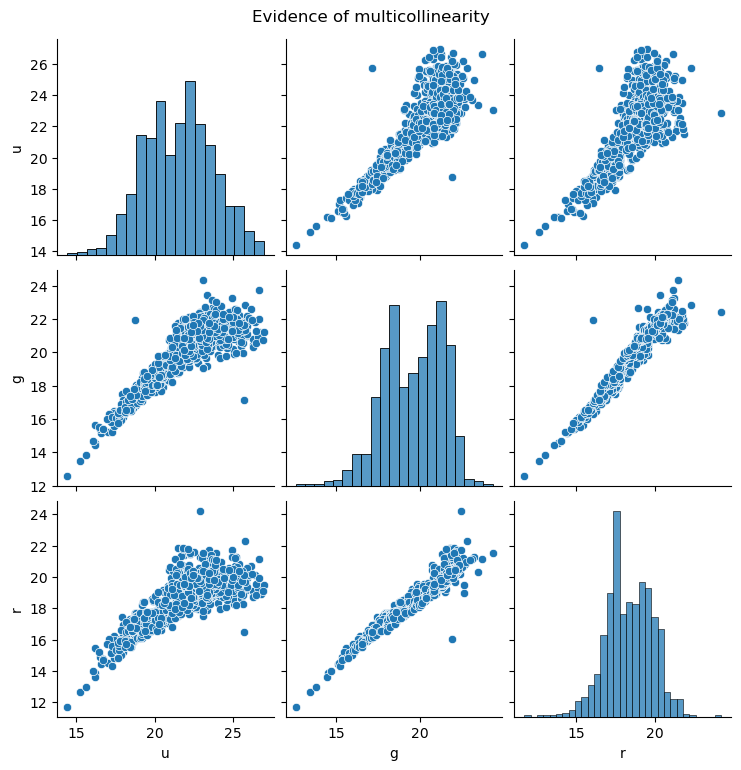

In [105]:
# Evidence of multicolinearity:
g = sns.pairplot(astro_data[['u', 'g', 'r']])
g.fig.suptitle('Evidence of multicollinearity', y=1.02)

[1] Kahn, S. M. et al. URL: www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf

[2] Gabriel B. Brammer, Pieter G. van Dokkum, Paolo Coppi (2008), Astrophys.J. 686 (2008) 1503, e-Print: 0807.1533 

Copyright @ IBM Corporation. All rights reserved.
